# WCG + Multi-Model Comparison

WCG（Woman-Child-Group）ベースの予測 + XGBoost, SVM, RandomForest, KNN とそのアンサンブルの比較

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('dark')
sns.set_palette('Set2')
import warnings
warnings.filterwarnings('ignore')

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

# 基本モデルのインポート
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC

try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
    print("✓ XGBoost available")
except ImportError:
    XGBOOST_AVAILABLE = False
    print("✗ XGBoost not available")

✓ XGBoost available


## データ読み込みとWCG特徴量の作成

In [2]:
train_data = pd.read_csv('../input/train.csv')
test_data = pd.read_csv('../input/test.csv')
data = pd.concat([train_data, test_data]).reset_index().drop(['index'], axis=1)

str_cols = data.select_dtypes(include=["object"]).columns
data[str_cols] = (data[str_cols]
                .apply(lambda s: s.str.strip())
                .replace(r"^\s*$", np.nan, regex=True))

if "Perished" in data and "Survived" not in data:
    data["Survived"] = 1 - data["Perished"]

print(f"Total data shape: {data.shape}")
print(f"Train data: {len(train_data)}")
print(f"Test data: {len(test_data)}")

Total data shape: (1309, 13)
Train data: 891
Test data: 418


In [3]:
data['Surname'] = data['Name'].apply(lambda x: x.split(',')[0])

In [4]:
# Ticket_id と Group_id の作成
data['Ticket_id'] = (data['Pclass'].astype(str) + '-' + 
                     data['Ticket'].str[:-1] + '-' + 
                     data['Fare'].astype(str) + '-' + 
                     data['Embarked'].astype(str))

data['Group_id'] = data['Surname'] + '-' + data['Ticket_id']

In [5]:
# Title特徴の作成
data['Title'] = 'man'
data.loc[data.Sex == 'female', 'Title'] = 'woman'
data.loc[data['Name'].str.contains('Master', na=False), 'Title'] = 'boy'

print("Title distribution:")
print(data['Title'].value_counts())

Title distribution:
Title
man      782
woman    466
boy       61
Name: count, dtype: int64


In [6]:
# WCG（Woman-Child-Group）の識別
data.loc[data.Title == 'man', 'Group_id'] = 'noGroup'
data['WC_count'] = data.loc[data.Title != 'man'].groupby('Group_id')['Group_id'].transform('count')
data.loc[data.WC_count <=1, 'Group_id'] = 'noGroup'

# グループへの追加
count = 0
for i in range(len(data)):
    if (data.loc[i,'Title'] != 'man') & (data.loc[i,'Group_id'] == 'noGroup'):
        matching = data.loc[(data['Ticket_id'] == data.loc[i, 'Ticket_id']) & (data.Title != 'man'), 'Group_id']
        if len(matching) > 0:
            data.loc[i,'Group_id'] = matching.iloc[0]
            if (data.loc[i, 'Group_id'] != 'noGroup'):
                count += 1
                
print(f'{count} passengers were added to an existing group')

# WCGの生存率
data['WCSurvived'] = data.loc[(data.Title != 'man') & (data.Group_id != 'noGroup')].groupby('Group_id').Survived.transform('mean')

# テストセットのみのグループ
test_groups = set(data[891:1309].Group_id.unique()) - set(data[0:891].Group_id.unique())
data.loc[data.Group_id.isin(test_groups), 'WCSurvived'] = 0
data.loc[(data.Group_id.isin(test_groups)) & (data.Pclass != 3), 'WCSurvived'] = 1

print(f"\nWCG groups found: {data.loc[data.Group_id != 'noGroup', 'Group_id'].nunique()}")
print(f"WCG passengers: {data.loc[data.Group_id != 'noGroup'].shape[0]}")

11 passengers were added to an existing group

WCG groups found: 80
WCG passengers: 230


In [7]:
# WCGベースの初期予測
data.loc[891:1308, 'Predict'] = 0
data.loc[(data.index >= 891) & (data.index <= 1308) & (data.Sex == 'female'), 'Predict'] = 1
data.loc[(data.index >= 891) & (data.index <= 1308) & (data.Sex == 'female') & (data['WCSurvived'] == 0), 'Predict'] = 0
data.loc[(data.index >= 891) & (data.index <= 1308) & (data.Title == 'boy') & (data['WCSurvived'] == 1), 'Predict'] = 1

In [8]:
# 1人あたりの運賃
data['Ticket_freq'] = data.groupby('Ticket')['Ticket'].transform('count')
data['Pfare'] = data['Fare'] / data['Ticket_freq']

## モデル訓練用データの準備

In [9]:
# 男性データ
train_male = data[0:891].loc[(data.Sex=='male') & (data.WCSurvived.isnull())]
test_male = data[891:1309].loc[(data.Sex=='male') & (data.WCSurvived.isnull())]

# 女性データ
train_female = data[0:891].loc[(data.Sex=='female') & (data.WCSurvived.isnull())]
test_female = data[891:1309].loc[(data.Sex=='female') & (data.WCSurvived.isnull())]

print(f"Train male: {len(train_male)}")
print(f"Test male: {len(test_male)}")
print(f"Train female: {len(train_female)}")
print(f"Test female: {len(test_female)}")

Train male: 537
Test male: 247
Train female: 198
Test female: 97


In [10]:
# 特徴量の設定
features = ['Pfare', 'Pclass', 'Embarked']

numerical_cols = ['Pfare']
categorical_cols = ['Pclass', 'Embarked']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

print(f"Features: {features}")

Features: ['Pfare', 'Pclass', 'Embarked']


## モデル定義：KNN, SVM, RandomForest, XGBoost + アンサンブル

In [11]:
# 基本モデルの定義
models = {}

# 1. KNN (k=1,3,5,7,9)
models['KNN_1'] = KNeighborsClassifier(n_neighbors=1)
models['KNN_3'] = KNeighborsClassifier(n_neighbors=3)
models['KNN_5'] = KNeighborsClassifier(n_neighbors=5)
models['KNN_7'] = KNeighborsClassifier(n_neighbors=7)
models['KNN_9'] = KNeighborsClassifier(n_neighbors=9)

# 2. SVM (複数カーネル)
models['SVM_RBF'] = SVC(kernel='rbf', probability=True, random_state=42, C=1.0)
models['SVM_Linear'] = SVC(kernel='linear', probability=True, random_state=42, C=1.0)
models['SVM_Poly'] = SVC(kernel='poly', degree=3, probability=True, random_state=42, C=1.0)

# 3. RandomForest (複数設定)
models['RF_50'] = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)
models['RF_100'] = RandomForestClassifier(n_estimators=100, max_depth=7, random_state=42)
models['RF_200'] = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)

# 4. XGBoost (利用可能な場合)
if XGBOOST_AVAILABLE:
    models['XGB_50'] = XGBClassifier(n_estimators=50, max_depth=3, learning_rate=0.1, random_state=42, eval_metric='logloss')
    models['XGB_100'] = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, eval_metric='logloss')
    models['XGB_200'] = XGBClassifier(n_estimators=200, max_depth=7, learning_rate=0.05, random_state=42, eval_metric='logloss')

# === アンサンブル ===

# 5. KNNアンサンブル
models['KNN_Ensemble_135'] = VotingClassifier([
    ('knn1', KNeighborsClassifier(n_neighbors=1)),
    ('knn3', KNeighborsClassifier(n_neighbors=3)),
    ('knn5', KNeighborsClassifier(n_neighbors=5))
], voting='hard')

models['KNN_Ensemble_357'] = VotingClassifier([
    ('knn3', KNeighborsClassifier(n_neighbors=3)),
    ('knn5', KNeighborsClassifier(n_neighbors=5)),
    ('knn7', KNeighborsClassifier(n_neighbors=7))
], voting='hard')

# 6. SVM アンサンブル
models['SVM_Ensemble'] = VotingClassifier([
    ('svm_rbf', SVC(kernel='rbf', probability=True, random_state=42)),
    ('svm_linear', SVC(kernel='linear', probability=True, random_state=42)),
    ('svm_poly', SVC(kernel='poly', degree=3, probability=True, random_state=42))
], voting='soft')

# 7. RandomForest アンサンブル
models['RF_Ensemble'] = VotingClassifier([
    ('rf50', RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)),
    ('rf100', RandomForestClassifier(n_estimators=100, max_depth=7, random_state=43)),
    ('rf200', RandomForestClassifier(n_estimators=200, max_depth=10, random_state=44))
], voting='soft')

# 8. XGBoost アンサンブル
if XGBOOST_AVAILABLE:
    models['XGB_Ensemble'] = VotingClassifier([
        ('xgb50', XGBClassifier(n_estimators=50, max_depth=3, learning_rate=0.1, random_state=42, eval_metric='logloss')),
        ('xgb100', XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=43, eval_metric='logloss')),
        ('xgb200', XGBClassifier(n_estimators=200, max_depth=7, learning_rate=0.05, random_state=44, eval_metric='logloss'))
    ], voting='soft')

# 9. 全体アンサンブル（KNN + SVM + RF + XGB）
ensemble_models = [
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('svm', SVC(kernel='rbf', probability=True, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=7, random_state=42))
]

if XGBOOST_AVAILABLE:
    ensemble_models.append(('xgb', XGBClassifier(n_estimators=100, max_depth=5, random_state=42, eval_metric='logloss')))

models['All_Ensemble_Hard'] = VotingClassifier(ensemble_models, voting='hard')
models['All_Ensemble_Soft'] = VotingClassifier(ensemble_models, voting='soft')

# 10. Best3 アンサンブル (後で動的に選択)
# これは評価後に追加

print(f"\nTotal models defined: {len(models)}")
print("\nModel categories:")
print(f"  KNN: {len([k for k in models.keys() if k.startswith('KNN')])}")
print(f"  SVM: {len([k for k in models.keys() if k.startswith('SVM')])}")
print(f"  RF: {len([k for k in models.keys() if k.startswith('RF')])}")
if XGBOOST_AVAILABLE:
    print(f"  XGB: {len([k for k in models.keys() if k.startswith('XGB')])}")
print(f"  Ensemble: {len([k for k in models.keys() if 'Ensemble' in k or 'All_' in k])}")


Total models defined: 21

Model categories:
  KNN: 7
  SVM: 4
  RF: 4
  XGB: 4
  Ensemble: 7


## 男性モデルの評価

In [12]:
# 男性データの準備
y_m = train_male['Survived']
X_m = train_male[features]

# 結果を格納するDataFrame
male_results = []

print("=" * 80)
print("MALE MODEL EVALUATION (15-Fold Cross-Validation)")
print("=" * 80)

for model_name, model in models.items():
    print(f"\nTraining {model_name}...", end=' ')
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    try:
        # クロスバリデーション
        cv_results = cross_validate(
            pipeline, X_m, y_m, cv=15,
            scoring=['accuracy', 'precision', 'recall', 'f1'],
            return_train_score=False,
            n_jobs=-1
        )
        
        male_results.append({
            'Model': model_name,
            'Accuracy': cv_results['test_accuracy'].mean(),
            'Accuracy_Std': cv_results['test_accuracy'].std(),
            'Precision': cv_results['test_precision'].mean(),
            'Recall': cv_results['test_recall'].mean(),
            'F1': cv_results['test_f1'].mean()
        })
        
        print(f"✓ Acc: {cv_results['test_accuracy'].mean():.4f}")
        
    except Exception as e:
        print(f"✗ Error: {str(e)[:50]}")

male_results_df = pd.DataFrame(male_results).sort_values('Accuracy', ascending=False)
print("\n" + "=" * 80)
print("MALE MODEL RESULTS (Top 10)")
print("=" * 80)
print(male_results_df.head(10).to_string(index=False))

MALE MODEL EVALUATION (15-Fold Cross-Validation)

Training KNN_1... ✓ Acc: 0.7765

Training KNN_3... ✓ Acc: 0.7989

Training KNN_5... ✓ Acc: 0.8419

Training KNN_7... ✓ Acc: 0.8437

Training KNN_9... ✓ Acc: 0.8232

Training SVM_RBF... ✓ Acc: 0.8437

Training SVM_Linear... ✓ Acc: 0.8399

Training SVM_Poly... 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

✓ Acc: 0.8419

Training RF_50... ✓ Acc: 0.8381

Training RF_100... 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


✓ Acc: 0.8343

Training RF_200... ✓ Acc: 0.8362

Training XGB_50... 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

✓ Acc: 0.8232

Training XGB_100... ✓ Acc: 0.8399

Training XGB_200... 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

✓ Acc: 0.8418

Training KNN_Ensemble_135... ✓ Acc: 0.8119

Training KNN_Ensemble_357... ✓ Acc: 0.8456

Training SVM_Ensemble... 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

✓ Acc: 0.8399

Training RF_Ensemble... 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


✓ Acc: 0.8362

Training XGB_Ensemble... ✓ Acc: 0.8437

Training All_Ensemble_Hard... ✓ Acc: 0.8399

Training All_Ensemble_Soft... ✓ Acc: 0.8419

MALE MODEL RESULTS (Top 10)
            Model  Accuracy  Accuracy_Std  Precision   Recall       F1
 KNN_Ensemble_357  0.845556      0.031457   0.563016 0.242222 0.313747
     XGB_Ensemble  0.843704      0.041233   0.510000 0.220000 0.289004
          SVM_RBF  0.843704      0.015932   0.133333 0.024444 0.041270
            KNN_7  0.843651      0.042723   0.604444 0.242222 0.323819
            KNN_5  0.841852      0.031040   0.489683 0.220000 0.285002
         SVM_Poly  0.841852      0.018446   0.133333 0.024444 0.041270
All_Ensemble_Soft  0.841852      0.037162   0.338889 0.164444 0.212381
          XGB_200  0.841799      0.042387   0.510000 0.231111 0.298264
       SVM_Linear  0.839947      0.011004   0.000000 0.000000 0.000000
     SVM_Ensemble  0.839947      0.011004   0.000000 0.000000 0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

## 女性モデルの評価

In [13]:
# 女性データの準備
y_f = train_female['Survived']
X_f = train_female[features]

# 死亡予測用のカスタムスコアラー
custom_precision = make_scorer(precision_score, pos_label=0, zero_division=0)
custom_recall = make_scorer(recall_score, pos_label=0)
custom_f1 = make_scorer(f1_score, pos_label=0)

# 結果を格納するDataFrame
female_results = []

print("=" * 80)
print("FEMALE MODEL EVALUATION (9-Fold Cross-Validation)")
print("=" * 80)

for model_name, model in models.items():
    print(f"\nTraining {model_name}...", end=' ')
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    try:
        # クロスバリデーション
        cv_results = cross_validate(
            pipeline, X_f, y_f, cv=9,
            scoring={
                'accuracy': 'accuracy',
                'precision': custom_precision,
                'recall': custom_recall,
                'f1': custom_f1
            },
            return_train_score=False,
            n_jobs=-1
        )
        
        female_results.append({
            'Model': model_name,
            'Accuracy': cv_results['test_accuracy'].mean(),
            'Accuracy_Std': cv_results['test_accuracy'].std(),
            'Precision': cv_results['test_precision'].mean(),
            'Recall': cv_results['test_recall'].mean(),
            'F1': cv_results['test_f1'].mean()
        })
        
        print(f"✓ Acc: {cv_results['test_accuracy'].mean():.4f}")
        
    except Exception as e:
        print(f"✗ Error: {str(e)[:50]}")

female_results_df = pd.DataFrame(female_results).sort_values('Accuracy', ascending=False)
print("\n" + "=" * 80)
print("FEMALE MODEL RESULTS (Top 10)")
print("=" * 80)
print(female_results_df.head(10).to_string(index=False))

FEMALE MODEL EVALUATION (9-Fold Cross-Validation)

Training KNN_1... ✓ Acc: 0.7677

Training KNN_3... ✓ Acc: 0.7374

Training KNN_5... ✓ Acc: 0.7980

Training KNN_7... ✓ Acc: 0.8081

Training KNN_9... ✓ Acc: 0.8232

Training SVM_RBF... ✓ Acc: 0.7929

Training SVM_Linear... ✓ Acc: 0.7929

Training SVM_Poly... ✓ Acc: 0.7929

Training RF_50... ✓ Acc: 0.7879

Training RF_100... ✓ Acc: 0.7980

Training RF_200... ✓ Acc: 0.8030

Training XGB_50... ✓ Acc: 0.7879

Training XGB_100... ✓ Acc: 0.7929

Training XGB_200... ✓ Acc: 0.7828

Training KNN_Ensemble_135... ✓ Acc: 0.7626

Training KNN_Ensemble_357... ✓ Acc: 0.7929

Training SVM_Ensemble... ✓ Acc: 0.8182

Training RF_Ensemble... ✓ Acc: 0.7929

Training XGB_Ensemble... ✓ Acc: 0.7828

Training All_Ensemble_Hard... ✓ Acc: 0.7929

Training All_Ensemble_Soft... ✓ Acc: 0.7879

FEMALE MODEL RESULTS (Top 10)
           Model  Accuracy  Accuracy_Std  Precision   Recall       F1
           KNN_9  0.823232      0.065851   0.600000 0.277778 0.352028
   

## 結果の可視化

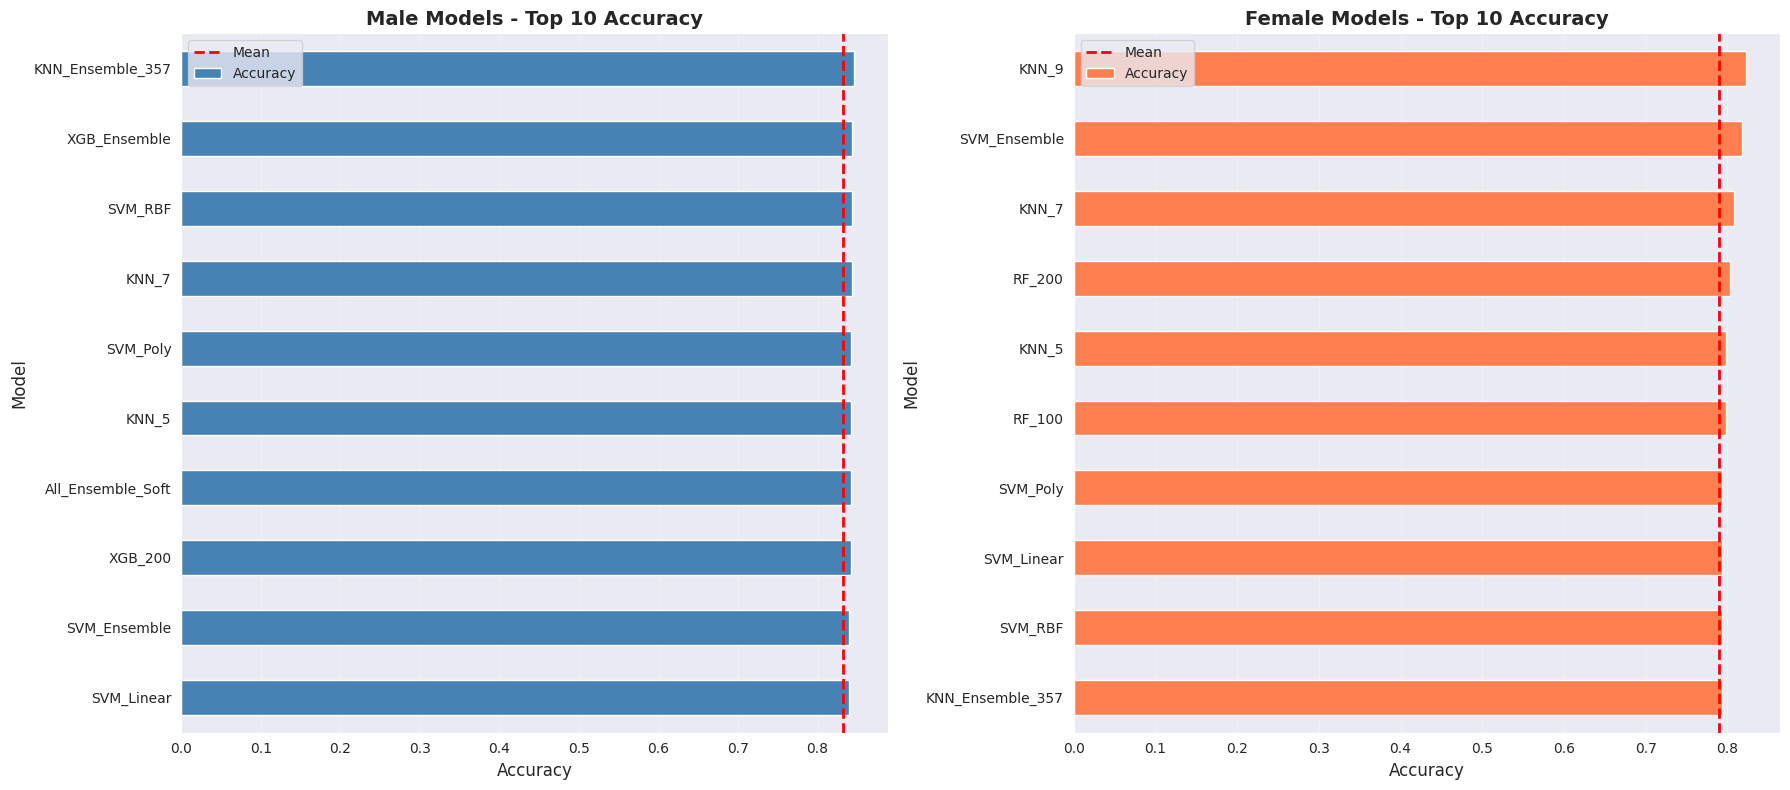

In [14]:
# Top 10 モデルの比較
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

male_top10 = male_results_df.head(10).sort_values('Accuracy')
male_top10.plot(x='Model', y='Accuracy', kind='barh', ax=ax[0], legend=False, color='steelblue')
ax[0].set_title('Male Models - Top 10 Accuracy', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Accuracy', fontsize=12)
ax[0].set_ylabel('Model', fontsize=12)
ax[0].axvline(x=male_results_df['Accuracy'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
ax[0].legend()
ax[0].grid(axis='x', alpha=0.3)

female_top10 = female_results_df.head(10).sort_values('Accuracy')
female_top10.plot(x='Model', y='Accuracy', kind='barh', ax=ax[1], legend=False, color='coral')
ax[1].set_title('Female Models - Top 10 Accuracy', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Accuracy', fontsize=12)
ax[1].set_ylabel('Model', fontsize=12)
ax[1].axvline(x=female_results_df['Accuracy'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
ax[1].legend()
ax[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

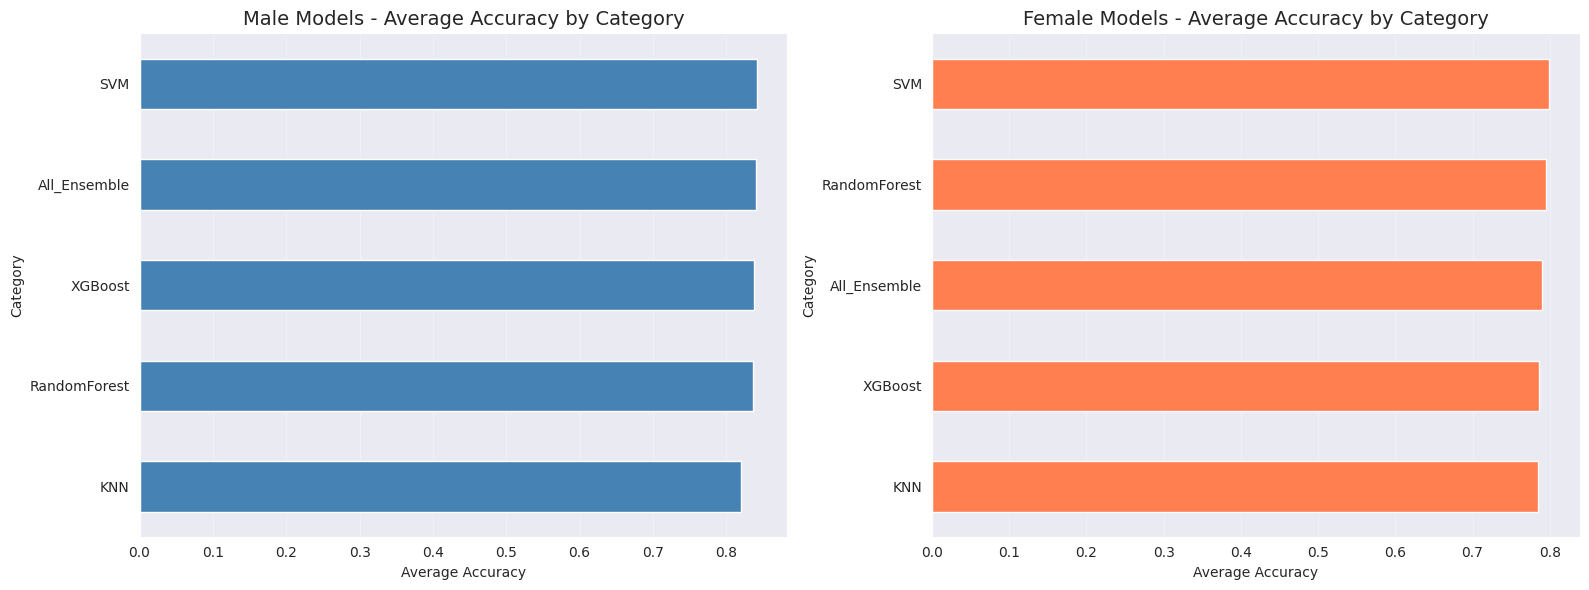

In [15]:
# カテゴリ別の比較
def categorize_model(name):
    if name.startswith('KNN'):
        return 'KNN'
    elif name.startswith('SVM'):
        return 'SVM'
    elif name.startswith('RF'):
        return 'RandomForest'
    elif name.startswith('XGB'):
        return 'XGBoost'
    elif 'All_' in name:
        return 'All_Ensemble'
    else:
        return 'Other'

male_results_df['Category'] = male_results_df['Model'].apply(categorize_model)
female_results_df['Category'] = female_results_df['Model'].apply(categorize_model)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

male_cat = male_results_df.groupby('Category')['Accuracy'].mean().sort_values()
male_cat.plot(kind='barh', ax=ax[0], color='steelblue')
ax[0].set_title('Male Models - Average Accuracy by Category', fontsize=14)
ax[0].set_xlabel('Average Accuracy')
ax[0].grid(axis='x', alpha=0.3)

female_cat = female_results_df.groupby('Category')['Accuracy'].mean().sort_values()
female_cat.plot(kind='barh', ax=ax[1], color='coral')
ax[1].set_title('Female Models - Average Accuracy by Category', fontsize=14)
ax[1].set_xlabel('Average Accuracy')
ax[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## アンサンブルモデルの詳細比較

In [16]:
# アンサンブルモデルのみを抽出
male_ensemble = male_results_df[male_results_df['Model'].str.contains('Ensemble|All_')].copy()
female_ensemble = female_results_df[female_results_df['Model'].str.contains('Ensemble|All_')].copy()

print("=" * 80)
print("ENSEMBLE MODELS COMPARISON")
print("=" * 80)

print("\n### MALE ENSEMBLE MODELS ###")
print(male_ensemble[['Model', 'Accuracy', 'Precision', 'Recall', 'F1']].to_string(index=False))

print("\n### FEMALE ENSEMBLE MODELS ###")
print(female_ensemble[['Model', 'Accuracy', 'Precision', 'Recall', 'F1']].to_string(index=False))

ENSEMBLE MODELS COMPARISON

### MALE ENSEMBLE MODELS ###
            Model  Accuracy  Precision   Recall       F1
 KNN_Ensemble_357  0.845556   0.563016 0.242222 0.313747
     XGB_Ensemble  0.843704   0.510000 0.220000 0.289004
All_Ensemble_Soft  0.841852   0.338889 0.164444 0.212381
     SVM_Ensemble  0.839947   0.000000 0.000000 0.000000
All_Ensemble_Hard  0.839947   0.355556 0.128889 0.179577
      RF_Ensemble  0.836243   0.395556 0.197778 0.250159
 KNN_Ensemble_135  0.811905   0.379127 0.266667 0.291284

### FEMALE ENSEMBLE MODELS ###
            Model  Accuracy  Precision   Recall       F1
     SVM_Ensemble  0.818182   0.000000 0.000000 0.000000
 KNN_Ensemble_357  0.792929   0.351852 0.194444 0.248677
All_Ensemble_Hard  0.792929   0.279630 0.250000 0.248677
      RF_Ensemble  0.792929   0.296296 0.222222 0.248677
All_Ensemble_Soft  0.787879   0.148148 0.083333 0.105820
     XGB_Ensemble  0.782828   0.214815 0.166667 0.179894
 KNN_Ensemble_135  0.762626   0.185185 0.138889 0.158730

## ベストモデルで予測

In [17]:
# ベストモデルの選択
best_male_model_name = male_results_df.iloc[0]['Model']
best_female_model_name = female_results_df.iloc[0]['Model']

print("=" * 80)
print("BEST MODELS SELECTED")
print("=" * 80)
print(f"\nMale model: {best_male_model_name}")
print(f"  Accuracy:  {male_results_df.iloc[0]['Accuracy']:.4f}")
print(f"  Precision: {male_results_df.iloc[0]['Precision']:.4f}")
print(f"  Recall:    {male_results_df.iloc[0]['Recall']:.4f}")
print(f"  F1:        {male_results_df.iloc[0]['F1']:.4f}")

print(f"\nFemale model: {best_female_model_name}")
print(f"  Accuracy:  {female_results_df.iloc[0]['Accuracy']:.4f}")
print(f"  Precision: {female_results_df.iloc[0]['Precision']:.4f}")
print(f"  Recall:    {female_results_df.iloc[0]['Recall']:.4f}")
print(f"  F1:        {female_results_df.iloc[0]['F1']:.4f}")
print("=" * 80)

BEST MODELS SELECTED

Male model: KNN_Ensemble_357
  Accuracy:  0.8456
  Precision: 0.5630
  Recall:    0.2422
  F1:        0.3137

Female model: KNN_9
  Accuracy:  0.8232
  Precision: 0.6000
  Recall:    0.2778
  F1:        0.3520


In [18]:
# ベストモデルで訓練と予測
best_male_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', models[best_male_model_name])
])

best_female_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', models[best_female_model_name])
])

# 男性モデルの訓練と予測
print("Training best male model...")
best_male_pipeline.fit(X_m, y_m)
X_test_m = test_male[features]
predictions_m = best_male_pipeline.predict(X_test_m)

# 女性モデルの訓練と予測
print("Training best female model...")
best_female_pipeline.fit(X_f, y_f)
X_test_f = test_female[features]
predictions_f = best_female_pipeline.predict(X_test_f)

print(f"\nMale predictions: {sum(predictions_m)} survived out of {len(predictions_m)}")
print(f"Female predictions: {sum(predictions_f)} survived out of {len(predictions_f)}")

Training best male model...
Training best female model...

Male predictions: 8.0 survived out of 247
Female predictions: 91.0 survived out of 97


In [19]:
import os

# Predictの更新
mask_male = (data.index >= 891) & (data.index <= 1308) & (data.Sex=='male') & (data.WCSurvived.isnull())
data.loc[mask_male, 'Predict'] = predictions_m

mask_female = (data.index >= 891) & (data.index <= 1308) & (data.Sex=='female') & (data.WCSurvived.isnull())
data.loc[mask_female, 'Predict'] = predictions_f

# Survived形式 → Perished形式に変換
output = pd.DataFrame({
    'PassengerId': data[891:1309].PassengerId, 
    'Perished': (1 - data[891:1309].Predict).astype('int')
})

os.makedirs('../output', exist_ok=True)
filename = f'wcg_best_{best_male_model_name}_{best_female_model_name}.csv'
output.to_csv(f'../output/{filename}', index=False)

print("\n" + "=" * 80)
print("SUBMISSION FILE SAVED")
print("=" * 80)
print(f"File: {filename}")
print(f"Total predictions: {len(output)}")
print(f"Predicted to die (Perished=1): {(output['Perished'] == 1).sum()}")
print(f"Predicted to survive (Perished=0): {(output['Perished'] == 0).sum()}")
print(f"Survival rate: {(output['Perished'] == 0).sum() / len(output) * 100:.2f}%")
print("=" * 80)


SUBMISSION FILE SAVED
File: wcg_best_KNN_Ensemble_357_KNN_9.csv
Total predictions: 418
Predicted to die (Perished=1): 271
Predicted to survive (Perished=0): 147
Survival rate: 35.17%


## 詳細サマリー

In [20]:
print("\n" + "=" * 80)
print("COMPREHENSIVE SUMMARY")
print("=" * 80)

print("\n" + "#" * 40)
print("# MALE MODELS")
print("#" * 40)
print("\n### Top 5 Overall ###")
print(male_results_df.head(5)[['Model', 'Accuracy', 'Precision', 'Recall', 'F1']].to_string(index=False))

print("\n### Best by Category ###")
for cat in ['KNN', 'SVM', 'RandomForest', 'XGBoost', 'All_Ensemble']:
    cat_models = male_results_df[male_results_df['Category'] == cat]
    if len(cat_models) > 0:
        best = cat_models.iloc[0]
        print(f"  {cat:15s}: {best['Model']:25s} (Acc: {best['Accuracy']:.4f})")

print("\n" + "#" * 40)
print("# FEMALE MODELS")
print("#" * 40)
print("\n### Top 5 Overall ###")
print(female_results_df.head(5)[['Model', 'Accuracy', 'Precision', 'Recall', 'F1']].to_string(index=False))

print("\n### Best by Category ###")
for cat in ['KNN', 'SVM', 'RandomForest', 'XGBoost', 'All_Ensemble']:
    cat_models = female_results_df[female_results_df['Category'] == cat]
    if len(cat_models) > 0:
        best = cat_models.iloc[0]
        print(f"  {cat:15s}: {best['Model']:25s} (Acc: {best['Accuracy']:.4f})")

print("\n" + "#" * 40)
print("# SELECTED FOR SUBMISSION")
print("#" * 40)
print(f"\nMale:   {best_male_model_name} (Accuracy: {male_results_df.iloc[0]['Accuracy']:.4f})")
print(f"Female: {best_female_model_name} (Accuracy: {female_results_df.iloc[0]['Accuracy']:.4f})")

print("\n" + "=" * 80)


COMPREHENSIVE SUMMARY

########################################
# MALE MODELS
########################################

### Top 5 Overall ###
           Model  Accuracy  Precision   Recall       F1
KNN_Ensemble_357  0.845556   0.563016 0.242222 0.313747
    XGB_Ensemble  0.843704   0.510000 0.220000 0.289004
         SVM_RBF  0.843704   0.133333 0.024444 0.041270
           KNN_7  0.843651   0.604444 0.242222 0.323819
           KNN_5  0.841852   0.489683 0.220000 0.285002

### Best by Category ###
  KNN            : KNN_Ensemble_357          (Acc: 0.8456)
  SVM            : SVM_RBF                   (Acc: 0.8437)
  RandomForest   : RF_50                     (Acc: 0.8381)
  XGBoost        : XGB_Ensemble              (Acc: 0.8437)
  All_Ensemble   : All_Ensemble_Soft         (Acc: 0.8419)

########################################
# FEMALE MODELS
########################################

### Top 5 Overall ###
       Model  Accuracy  Precision   Recall       F1
       KNN_9  0.823232   0

In [21]:
# 結果をCSVで保存
male_results_df.to_csv('../output/male_model_results.csv', index=False)
female_results_df.to_csv('../output/female_model_results.csv', index=False)

print("Model evaluation results saved to:")
print("  - ../output/male_model_results.csv")
print("  - ../output/female_model_results.csv")

Model evaluation results saved to:
  - ../output/male_model_results.csv
  - ../output/female_model_results.csv
